In [3]:
import os
import cv2
import deeplabcut
import matplotlib.pyplot as plt
import json
import numpy as np

from PIL import Image

from tqdm import tqdm
from IPython.display import display
from pathlib import Path
from dotenv import find_dotenv, load_dotenv

video_dir = Path(os.environ['MFE_PROCESSED_VIDEOS']) 
project_dir = Path('..').resolve()
load_dotenv(find_dotenv())

bodyparts = [
    'nose',
    'left_eye',
    'left_ear',
    'right_eye',
    'right_ear',
    # 'clavicle_region',
    # 'spine',
    # 'hip_region',
    # 'tailbase',
    # 'tailtip',
    # 'left_elbow',
    # 'left_wrist',
    # 'left_finger',
    # 'left_knee',
    # 'left_ankle',
    # 'left_toes',
    # 'right_elbow',
    # 'right_wrist',
    # 'right_finger',
    # 'right_knee',
    # 'right_ankle',
    # 'right_toes'
]

Loading DLC 2.3.5...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/opt/anaconda3/envs/mfe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create the DLC Project

In [23]:
deeplabcut_project_config = deeplabcut.create_new_project(
    project='mouse_face',
    experimenter='telfer',
    videos=[project_dir/'data/raw/placeholder.mp4'], # should be the same size as all other videos
    copy_videos=False,
    working_directory=project_dir/'data/dlc'
)

deeplabcut_project = Path(deeplabcut_project_config).parent

Created "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/videos"
Created "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/labeled-data"
Created "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/training-datasets"
Created "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /Users/andretelfer/repos/mouse_facial_expressions_2023/data/raw/placeholder.mp4 to /Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/videos/placeholder.mp4
/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/videos/placeholder.mp4
Generated "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27/config.yaml"

A new project with name mouse

In [24]:
config = deeplabcut.auxiliaryfunctions.read_config(deeplabcut_project_config)
print(json.dumps(config, indent=4))

{
    "Task": "mouse_face",
    "scorer": "telfer",
    "date": "Jun27",
    "multianimalproject": false,
    "identity": null,
    "project_path": "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/dlc/mouse_face-telfer-2023-06-27",
    "video_sets": {
        "/Users/andretelfer/repos/mouse_facial_expressions_2023/data/raw/placeholder.mp4": {
            "crop": "0, 1920, 0, 1200"
        }
    },
    "bodyparts": [
        "bodypart1",
        "bodypart2",
        "bodypart3",
        "objectA"
    ],
    "start": 0,
    "stop": 1,
    "numframes2pick": 20,
    "skeleton": [
        [
            "bodypart1",
            "bodypart2"
        ],
        [
            "objectA",
            "bodypart3"
        ]
    ],
    "skeleton_color": "black",
    "pcutoff": 0.6,
    "dotsize": 12,
    "alphavalue": 0.7,
    "colormap": "rainbow",
    "TrainingFraction": [
        0.95
    ],
    "iteration": 0,
    "default_net_type": "resnet_50",
    "default_augmenter": "default",
  

In [41]:
video_sets = config['video_sets']
placeholder_video, placeholder_crop = list(video_sets.items())[0]

video_sets = {
    'phase1.mp4': {**placeholder_crop},
    'phase2.mp4': {**placeholder_crop},
    'phase3.mp4': {**placeholder_crop},
    'phase4.mp4': {**placeholder_crop}
}
config['video_sets'] = video_sets
config['bodyparts'] = bodyparts

deeplabcut.auxiliaryfunctions.write_config(deeplabcut_project_config, config)

## Extract Frames

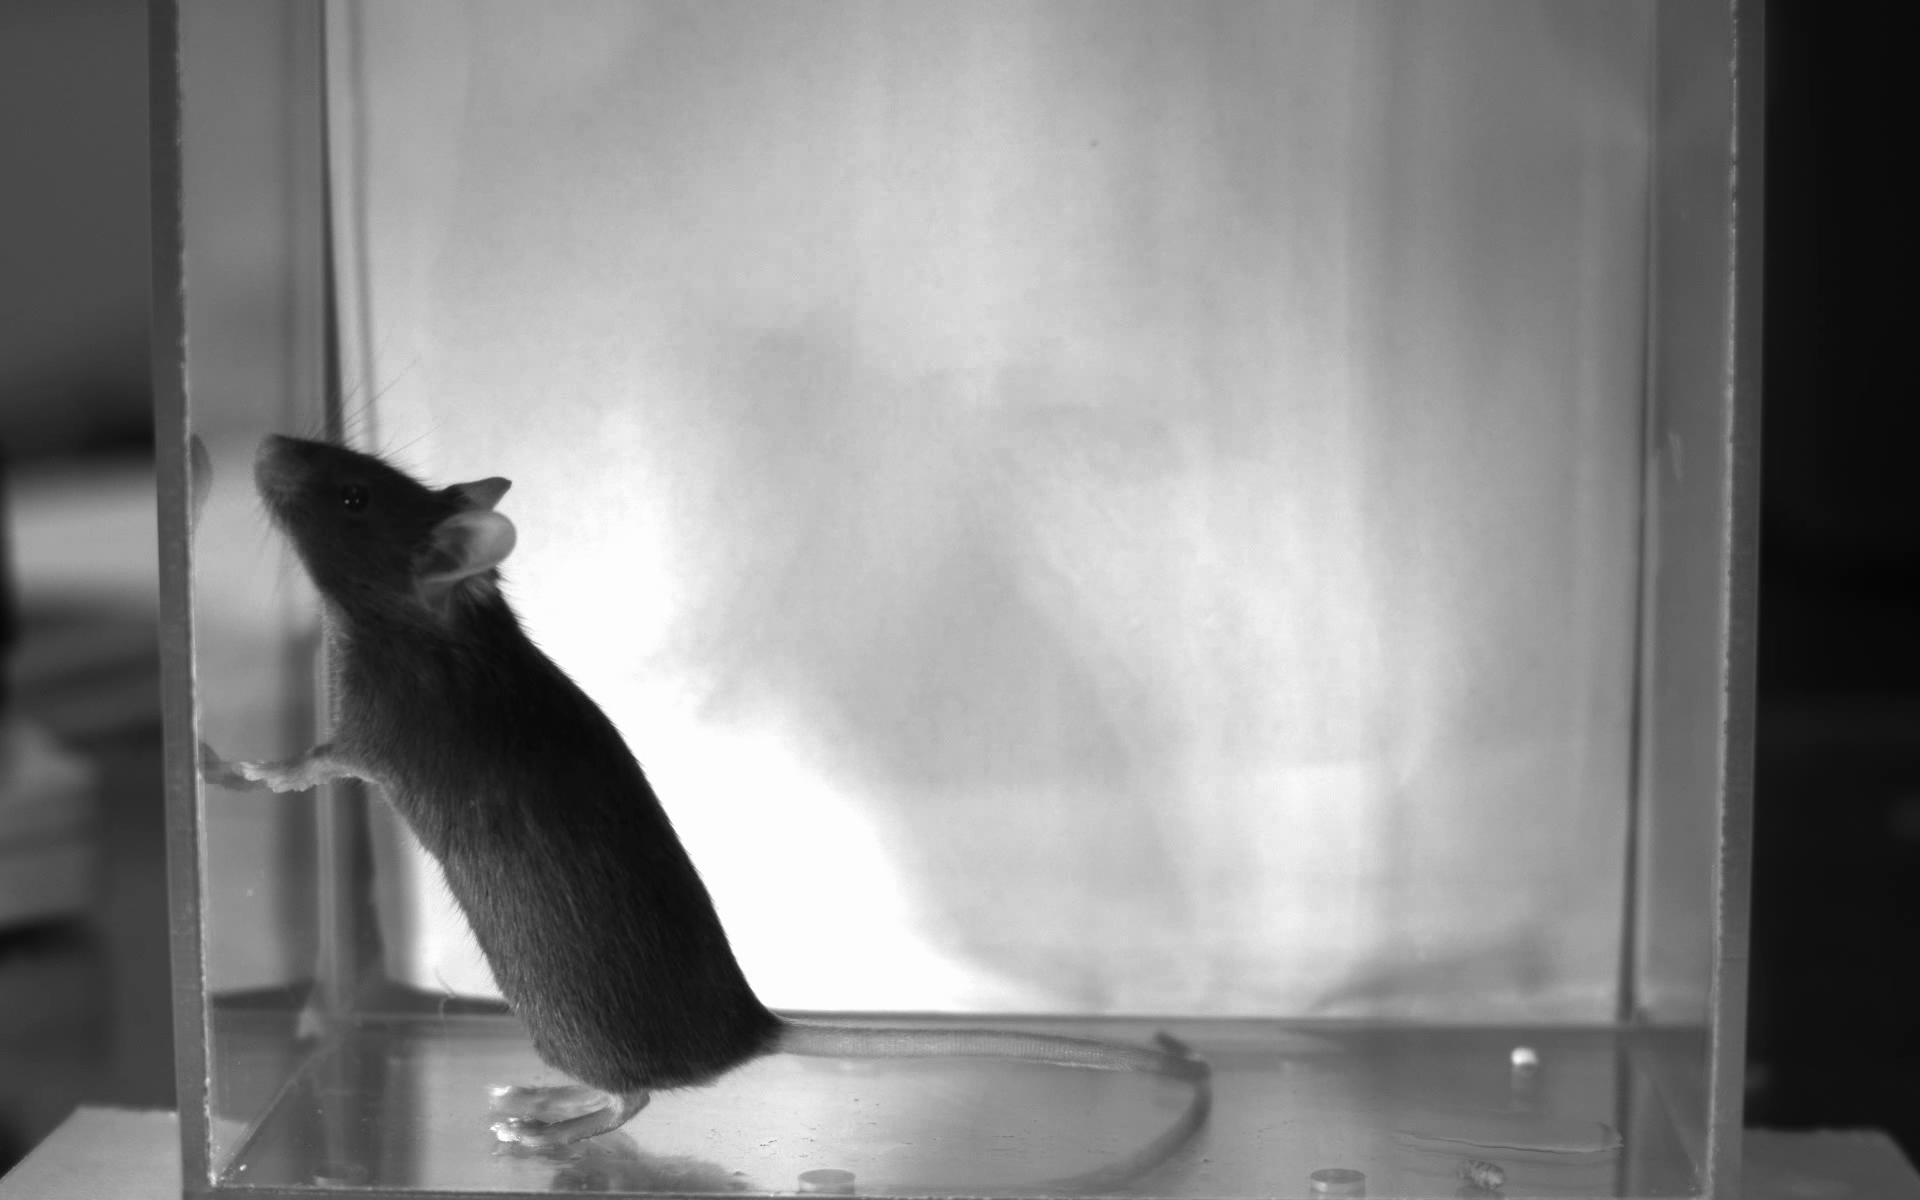

In [23]:
raw_videos = list(Path(os.environ['MFE_RAW_VIDEOS']).glob('*.mp4'))
output_dir = project_dir / 'reports/figures/raw_frame_examples'
if not output_dir.exists():
    output_dir.mkdir(parents=True)

video = raw_videos[10]
cap = cv2.VideoCapture(str(video))

frames = [5000,]
for frame_idx in frames:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    frame = Image.fromarray(frame)
    display(frame)

    fname, _ = video.parts[-1].split('.')
    frame.save(output_dir / f"{fname}_frame{frame_idx:05}.png")

In [4]:
def extract_frames_from_video(video, n_frames, save_to):
    save_to = Path(save_to)
    if not save_to.exists():
        save_to.mkdir(parents=True)
        
    cap = cv2.VideoCapture(str(video))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frames == 0:
        return 
    
    selected_frames = np.random.choice(np.arange(frames), n_frames)
    fname, _ = Path(video).parts[-1].split('.')
    
    for i in selected_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        
        frame = Image.fromarray(frame)
        frame.save(save_to / f"{fname}_frame{i:05}.png")

### Phase 1 Frames

In [42]:
videos = [
    video_dir / 'f16_rec1_preinjection.mp4',
    video_dir / 'f30_rec1_preinjection.mp4',
    video_dir / 'm18_rec1_preinjection.mp4',
    video_dir / 'm25_rec1_preinjection.mp4',
]

np.random.seed(42)
for video in videos:
    extract_frames_from_video(video, 50, save_to=deeplabcut_project / 'labeled-data/phase1')

### Phase 2

In [11]:
deeplabcut_project = Path('../data/dlc/mouse_face-telfer-2023-06-27')

videos = [
    video_dir / 'm1_rec1_preinjection.mp4',
    video_dir / 'm4_rec1_preinjection.mp4',
    video_dir / 'm19_rec1_preinjection.mp4',
    video_dir / 'm29_rec3_2h-postinjection.mp4',

    video_dir / 'm24_rec1_preinjection.mp4',
    video_dir / 'm24_rec4_4h-postinjection.mp4',
    video_dir / 'm22_rec4_4h-postinjection.mp4',
    video_dir / 'f1_rec1_preinjection.mp4',

    video_dir / 'f4_rec1_preinjection.mp4',
    video_dir / 'f33_rec3_2h-postinjection.mp4',
    video_dir / 'f24_rec4_4h-postinjection.mp4',
    video_dir / 'f27_rec1_preinjection.mp4',

    video_dir / 'f27_rec4_4h-postinjection.mp4',
    video_dir / 'f15_rec1_preinjection.mp4',
    video_dir / 'f15_rec4_4h-postinjection.mp4',
    video_dir / 'f12_rec1_preinjection.mp4',

    video_dir / 'f1_rec1_preinjection.mp4',
    video_dir / 'f2_rec1_preinjection.mp4',
    video_dir / 'm10_rec1_preinjection.mp4',
    video_dir / 'm11_rec1_preinjection.mp4',
]

for video in videos:
    assert video.exists(), video

np.random.seed(42)
for video in tqdm(videos):
    extract_frames_from_video(video, 50, save_to=deeplabcut_project / 'labeled-data/phase2')

100%|██████████| 20/20 [06:46<00:00, 20.34s/it]


### Phase 3 
Sample 10 frames from each video

In [6]:
deeplabcut_project = Path('../data/dlc/mouse_face-telfer-2023-06-27')

sample_n_frames = 10
for video in tqdm(list(video_dir.glob('*.mp4'))):
    extract_frames_from_video(video, 10, save_to=deeplabcut_project / 'labeled-data/phase3')

100%|█████████▉| 288/289 [18:13<00:03,  3.70s/it][mov,mp4,m4a,3gp,3g2,mj2 @ 0x29bb2f750] moov atom not found
OpenCV: Couldn't read video stream from file "/Volumes/LAB-DRIVE/telfer-thesis/processed-videos/20230627/._f24_rec4_4h-postinjection.mp4"
100%|██████████| 289/289 [18:13<00:00,  3.78s/it]
